# HQNSL for 1-qubit operations
This notebook is a test of the HQNSL scheme for the simplest parametrization of a quantum circuit: a collection of `depth` sets of `L` 1-qubit rotations given by `L x 2` parameters per set. We will learn in 2 bases and examine the effectiveness of the algorithm.

In [110]:
from __helpers import qubit_expansion, prepare_basis, rand_basis
from ___constants import PARAM_PER_QUBIT_PER_DEPTH
from __loss_funcs import KL
from __class_BasisTransformer import BasisTransformer
from __class_PQC import PQC
from __class_HQNet import HQNet
import matplotlib.pyplot as plt
import numpy as np
import torch as t
from math import pi
from qiskit.quantum_info import Statevector
%matplotlib inline

## Construction of the State

In [111]:
"""
The below flags control all the main parts of a run. The only things you
would need to change besides these is the optimization parameters, like which
algorithm to use, learning rate, maximum iterations, etc.
"""
CIRCUIT_DEPTH = 2 # Depth of the parameterized quantum circuit
STATE_TYPE = 'GHZ'
NUM_QUBITS = 7
USE_REGULARIZER = False

           ┌───┐                              
q333688_0: ┤ H ├──■────■────■────■────■────■──
           └───┘┌─┴─┐  │    │    │    │    │  
q333688_1: ─────┤ X ├──┼────┼────┼────┼────┼──
                └───┘┌─┴─┐  │    │    │    │  
q333688_2: ──────────┤ X ├──┼────┼────┼────┼──
                     └───┘┌─┴─┐  │    │    │  
q333688_3: ───────────────┤ X ├──┼────┼────┼──
                          └───┘┌─┴─┐  │    │  
q333688_4: ────────────────────┤ X ├──┼────┼──
                               └───┘┌─┴─┐  │  
q333688_5: ─────────────────────────┤ X ├──┼──
                                    └───┘┌─┴─┐
q333688_6: ──────────────────────────────┤ X ├
                                         └───┘


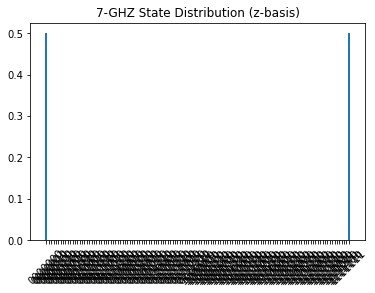

In [112]:
"""[Notes on the states]

Confusingly, the cluster state is actually NUM_QUBITS^2 qubits rather than NUM_QUBITS. 
This is due to the way the circuit is designed. The rest are as you would expect.
"""

if STATE_TYPE == 'GHZ':
    # Prepare: GHZ State (from: Q-circuit)
    from GHZ_generator import GHZ_state_circuit
    state = Statevector.from_int(0, 2**NUM_QUBITS)
    qc = GHZ_state_circuit(L=NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
elif STATE_TYPE == 'XY':
    # Prepare: XY(L) (from: ED)
    from XY_generator import xy_ground_state
    state = Statevector(xy_ground_state(NUM_QUBITS).numpy())
elif STATE_TYPE == 'Cluster':
    # Prepare cluster(L) (from: Q-circuit)
    from cluster_generator import cluster_state_circuit
    state = Statevector.from_int(0, 2**(NUM_QUBITS**2))
    qc = cluster_state_circuit(NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
else:
    raise TypeError("Invalid state type specified.")
param_shape = (state.num_qubits, CIRCUIT_DEPTH+1, PARAM_PER_QUBIT_PER_DEPTH)

# Visualize the distribution
plt.bar(qubit_expansion(state.num_qubits), state.probabilities())
plt.xticks(rotation=45)
plt.title(f"{NUM_QUBITS}-{STATE_TYPE} State Distribution (z-basis)")
plt.show()

## HQN Training
We will construct the bases we want as a list of `L x 3` rotation-parameter matrices, then pass them into the hybrid quantum net and run the optimization algorithm. 

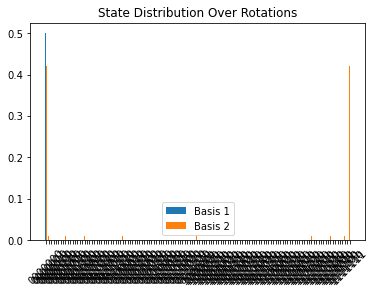

In [113]:
# Preparation of two bases
bases = prepare_basis(state.num_qubits)
num_bases = len(bases)

# Visualize the distribution of the bases
fig, ax = plt.subplots()
for i, basis in enumerate(bases):
    dist_i = BasisTransformer([state], basis).updated_dist()[0]
    bar = ax.bar(np.arange(2**state.num_qubits) + 0.25*i - 0.04*state.num_qubits, dist_i, width=0.25)
    bar.set_label(f"Basis {i+1}")
plt.legend()
ax.set_xticks(np.arange(2**state.num_qubits))
ax.set_xticklabels(qubit_expansion(state.num_qubits))
plt.xticks(rotation=45)
plt.title("State Distribution Over Rotations")
plt.show()

Classical deep net of circuit depth 2 initialized.
Classical deep net of circuit depth 2 initialized.
Parametrized quantum circuit initialized.
Parametrized quantum circuit initialized.
7-qubit non-regularized 'Nelder-Mead' hybrid quantum net initialized -- Hello world!


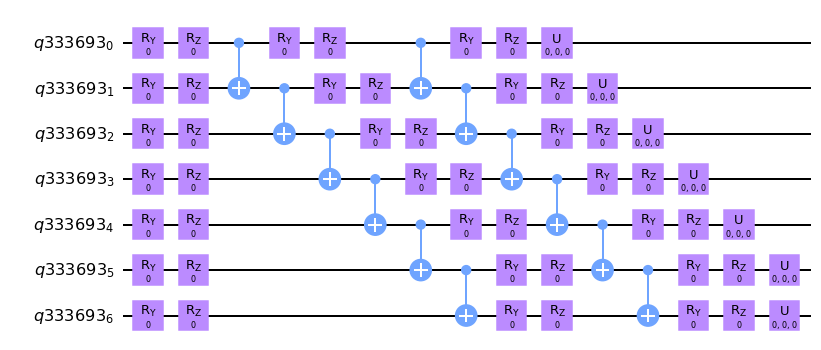

In [114]:
# Start up the HQN
disp = False # Display convergence messages from optimizer

hqn = HQNet(state, bases, eta=1e-2, maxiter=5E4, disp=disp,
            mode='Nelder-Mead', depth=CIRCUIT_DEPTH, 
            metric_func=KL, regularize=False)

# Examine the parametrized circuit
hqn.view_circuit().draw(output='mpl')

In [115]:
# Optimize a few times.
NRUN = 1
param_dim = np.prod(param_shape)
proposed_syms = t.zeros((NRUN, param_dim))
avg = 0
for i in range(NRUN):
    if disp:
        print(f"== Run {i+1}/{NRUN} ==")
    potential_sym, loss, regularizer_loss = hqn.find_potential_symmetry(print_log=True)
    proposed_syms[i] = potential_sym if t.is_tensor(potential_sym) else t.from_numpy(potential_sym)
    potential_sym = potential_sym.reshape(param_shape)
    if disp:
        print(f"Proposed symmetry:\n{potential_sym}\n")
    avg += loss / NRUN
print(f"\nAverage loss: {avg}")

# ? | Ooen question: `regularizer_loss` gives a list (one element per basis) of losses over time
# ? | that the regularizer CNets report during their batch training. These can be plotted
# ? | to see how well the regularizer is learning. In particular, if the paths start out in
# ? | totally different parts of the manifold, does the regularizer learn it well? If so, we 
# ? | are in trouble. We want the CNets to intentionally overfit, so it extrapolates relatively
# ? | poorly.

Optimized to QKL = 3.73520997660505e-14
Queried loss func 44659 times

Average loss: 3.73520997660505e-14


### LD-GHZ Scalability
At least for a small number of qubits, the query complexity seems to scale linearly or sublinearly with the circuit depth.

* Nelder-Mead query complexity appears to scale exponentially with number of qubits.
* NFT scales a bit better, but is not accurate either.
* 3 qubits, `depth = k`, `2500 * k` queries. 
* 4 qubits, `depth = 3`, 16000 queries. Doesn't seem to depend on depth.
* 5 qubits, `depth = 2`, 15000 queries.
* 6 qubits, `depth = 2`, 13000 queries.
* 7 qubits, `depth = 2`, 26000-45000 queries.

There is evidently a sharp query complexity increase at 7 qubits. What is happening?
The number of parameters is `L x D x 2`. The adaptive Nelder-Mead algorithm apparently adaps well up to 30 
parameters or so, then takes much longer to search. Nonteheless, accuracy was not compromised, which is good news.

### Comparison of Optimizers in 3-GHZ
tl;dr Nelder-Mead and NFT works best

We define `LA = A | B` to be the average loss `A` over `B` runs, throwing out extreme outliers. Times given are per run. The below results are for the 3-qubit GHZ state.

#### Local optimizers
1. Vanilla gradient descent is extremely slow (`~3 min`) and performs moderately poorly (`LA = 0.021 | 100`)
2. Adam is super fast (`<1 sec`) but performs very poorly (`LA = 3.77 | 1000`)
3. Nelder-Mead is very fast (`~5 sec`) and performs very well, needs `~1000` queries (`LA = 1e-14 | 100`).
4. Conjugate gradient is super fast (`<1 sec`) but performs very poorly (`LA = 3.171 | 1000`)
5. NFT is very fast (`~5 sec`) and performs well (`LA = 1e-5 | 100`).
6. SPSA is very slow (`~40 sec`) and performs reasonably well (`LA = 0.0036 | 100`)
7. TNC is extremely fast (`<<1 sec`) but performs very poorly (`LA = 3.62 | 1000`)
8. AQGD: I cannot get it to run. Seems like they are running some strange batch training which is not compatible
with my loss function `param_to_quantum_loss`. Too bad.

#### Global optimizers
1. TODO


## Quantum Training Validation
The quantum loss function is a sum over the classical loss metric projected into each basis, so let's first make sure that
the loss is uniformly and sufficiently small in each of the bases we used in the search.

In [116]:
# Look at the final KL divergence in each of the chosen bases.
for i, sym in enumerate(proposed_syms):
    if i > 0:
        print("\n")
    print(f"Analysing proposed symmetry {i+1}:\n{sym.reshape(param_shape)}\n")
    for basis_here in bases:
        loss_metric = PQC(state, depth=CIRCUIT_DEPTH, basis_param=basis_here, metric_func=KL, say_hi=False).evaluate_true_metric(sym)
        print(f"\tLoss metric for training basis {basis_here[0]} is: {loss_metric}")

Analysing proposed symmetry 1:
tensor([[[ 1.1440e+00,  1.5680e-05],
         [ 1.5708e+00,  6.2832e+00],
         [ 1.5708e+00,  3.4540e+00]],

        [[ 6.2832e+00,  6.2115e+00],
         [ 4.7124e+00,  3.1416e+00],
         [ 1.5708e+00,  2.6276e+00]],

        [[ 3.1416e+00,  4.7447e+00],
         [ 4.7124e+00,  6.2832e+00],
         [ 1.5708e+00,  9.2458e+00]],

        [[ 3.1416e+00,  5.8705e+00],
         [ 1.5708e+00, -1.2756e-07],
         [ 1.5708e+00,  3.5103e+00]],

        [[ 3.1416e+00,  3.4315e+00],
         [ 4.7124e+00,  2.9185e-08],
         [ 1.5708e+00,  6.4221e-01]],

        [[-6.5334e-09,  5.2324e-02],
         [ 1.5708e+00,  3.1416e+00],
         [ 1.5708e+00,  9.6396e-02]],

        [[ 2.6764e-01,  1.5708e+00],
         [ 4.7124e+00,  6.5508e+00],
         [ 4.2681e-01, -6.5490e-01]]])

	Loss metric for training basis tensor([0., 0., 0.]) is: 3.58609560158869e-14
	Loss metric for training basis tensor([0.3142, 0.0000, 0.0000]) is: 4.952063459698777e-14


## Quantum Loss Cross-Validation
We chose a small number of bases to run the quantum loss scheme over. But are those bases enough? 
If the proposed symmetries are truly symmetries, then they will be a symmetry in every basis. We shall test
these proposed symmetries by choosing some random bases, applying the quantum circuit, and examining the loss metric there.

If the loss metric is high there, then we did not use enough bases in the quantum loss function.

Note that this has more general implications, as the number of bases necessary to achieve a good quantum loss function
informs the amount of information necessary to construct a reasonable tomography of the state.

In [117]:
# Choose some random bases to examine.
NUM_RAND_BASES = 3 # arbitrary
for i, sym in enumerate(proposed_syms):
    if i > 0:
        print("\n")
    print(f"Analysing proposed symmetry {i+1}:\n{sym.reshape(param_shape)}\n")
    for _ in range(NUM_RAND_BASES):
        basis_here = rand_basis(state.num_qubits)
        loss_metric = PQC(state, basis_param=basis_here, depth=CIRCUIT_DEPTH, metric_func=KL, say_hi=False).evaluate_true_metric(sym)
        print(f"\tLoss metric for random basis {basis_here[0].numpy()} is: {loss_metric}")
    print('\n')

Analysing proposed symmetry 1:
tensor([[[ 1.1440e+00,  1.5680e-05],
         [ 1.5708e+00,  6.2832e+00],
         [ 1.5708e+00,  3.4540e+00]],

        [[ 6.2832e+00,  6.2115e+00],
         [ 4.7124e+00,  3.1416e+00],
         [ 1.5708e+00,  2.6276e+00]],

        [[ 3.1416e+00,  4.7447e+00],
         [ 4.7124e+00,  6.2832e+00],
         [ 1.5708e+00,  9.2458e+00]],

        [[ 3.1416e+00,  5.8705e+00],
         [ 1.5708e+00, -1.2756e-07],
         [ 1.5708e+00,  3.5103e+00]],

        [[ 3.1416e+00,  3.4315e+00],
         [ 4.7124e+00,  2.9185e-08],
         [ 1.5708e+00,  6.4221e-01]],

        [[-6.5334e-09,  5.2324e-02],
         [ 1.5708e+00,  3.1416e+00],
         [ 1.5708e+00,  9.6396e-02]],

        [[ 2.6764e-01,  1.5708e+00],
         [ 4.7124e+00,  6.5508e+00],
         [ 4.2681e-01, -6.5490e-01]]])

	Loss metric for random basis [0.01533382 2.785503   1.149591  ] is: 2.950617779535079e-10
	Loss metric for random basis [0.04824213 4.5755887  0.88145363] is: 2.352709596741589